# Clustering

In [73]:
import pandas as pd
import numpy as np
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

import umap

from config import *
from clustering_utils import *

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette='tab10', rc=custom_params)
plt.rcParams['figure.dpi'] = 300

import warnings
warnings.filterwarnings("ignore")

## Load data

In [74]:
features_raw_new = pd.read_parquet(FEATURES_DIR / "all_features.pq")
features_raw_new.shape

(192, 520)

In [75]:
# Drop participants where all features are null
features = features_raw_new[~(features_raw_new.isna().sum(axis=1) == features_raw_new.shape[1]-2)]
features.shape

(171, 520)

In [76]:
y = pd.DataFrame(features["y"], columns=["y"])
X = features.drop(["participant_id", "y"], axis=1)
X.shape

(171, 518)

## Dimensionality Reduction

In [77]:
X_reduced = X.pipe(remove_low_variance_features).pipe(remove_multicollineraity, y).pipe(remove_outliers, 'MAD', 10.0)

2025-05-12 10:27:17,131 - INFO - clustering_utils.remove_low_variance_features:50 - Kept 463 features out of 518
2025-05-12 10:27:17,374 - INFO - clustering_utils.remove_multicollineraity:108 - Removed 164 highly correlated features: {'FIXATIONS_fixations_per_second_median', 'FITTS_LAW_fixation_overshoot_max', 'SHAPES_duration_max_sacc', 'SHAPES_distance_to_fixpoint_mean', 'SHAPES_duration_max_fix', 'SMOOTH_PURSUITS_amplitude_mean_sacc', 'SMOOTH_PURSUITS_total_acceleration_magnitude_max', 'SHAPES_fixation_distance_std', 'SMOOTH_PURSUITS_duration_median_fix', 'SMOOTH_PURSUITS_fixations_per_second_median', 'FITTS_LAW_fixations_per_second_max', 'FITTS_LAW_total_acceleration_magnitude_median', 'FIXATIONS_distance_to_fixpoint_mean', 'FIXATIONS_saccades_per_second_max', 'KING_DEVICK_saccades_per_second_min', 'SMOOTH_PURSUITS_duration_mean_fix', 'EVIL_BASTARD_saccades_per_second_mean', 'FITTS_LAW_fixations_per_second_std', 'EVIL_BASTARD_fixation_distance_std', 'EVIL_BASTARD_fixation_distance_

In [78]:
X_reduced.shape

(171, 299)

## Choose Clustering Method

In [79]:
features_reduced = features[["participant_id", "y"] + list(X_reduced.columns)]

patients = features_reduced.query("y==1").drop(["participant_id", "y"], axis=1).dropna()
patients_std = pd.DataFrame(StandardScaler().fit_transform(patients), columns=patients.columns)


In [80]:
patients.shape

(55, 299)

## UMAP

In [238]:
params = {
        "n_neighbors" : [5,10,15,20],
        "min_dist" : [0.0,0.1,0.5],
        "metric" : ["euclidean", "manhattan"]
    }

In [139]:
def plot_umap(X, metric, n_neighbors, min_dist, ax, set_title=True):

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,         # smaller = more local focus, higher = more global
        min_dist=min_dist,           # smaller = tighter clusters, higher = more spread
        n_components=2,         
        metric=metric,     
        random_state=42
    )
    
    X_transformed = umap_model.fit_transform(X)

    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], palette="tab10", s=20, alpha=0.8, ax=ax, legend=False)
    
    # Layout
    if set_title == True:
        ax.set_title(f"n_neighbors: {n_neighbors}\n min_dist: {min_dist}", fontsize=8) # Set title
    ax.tick_params(axis='both', labelsize=6) # Reduce tick label font size

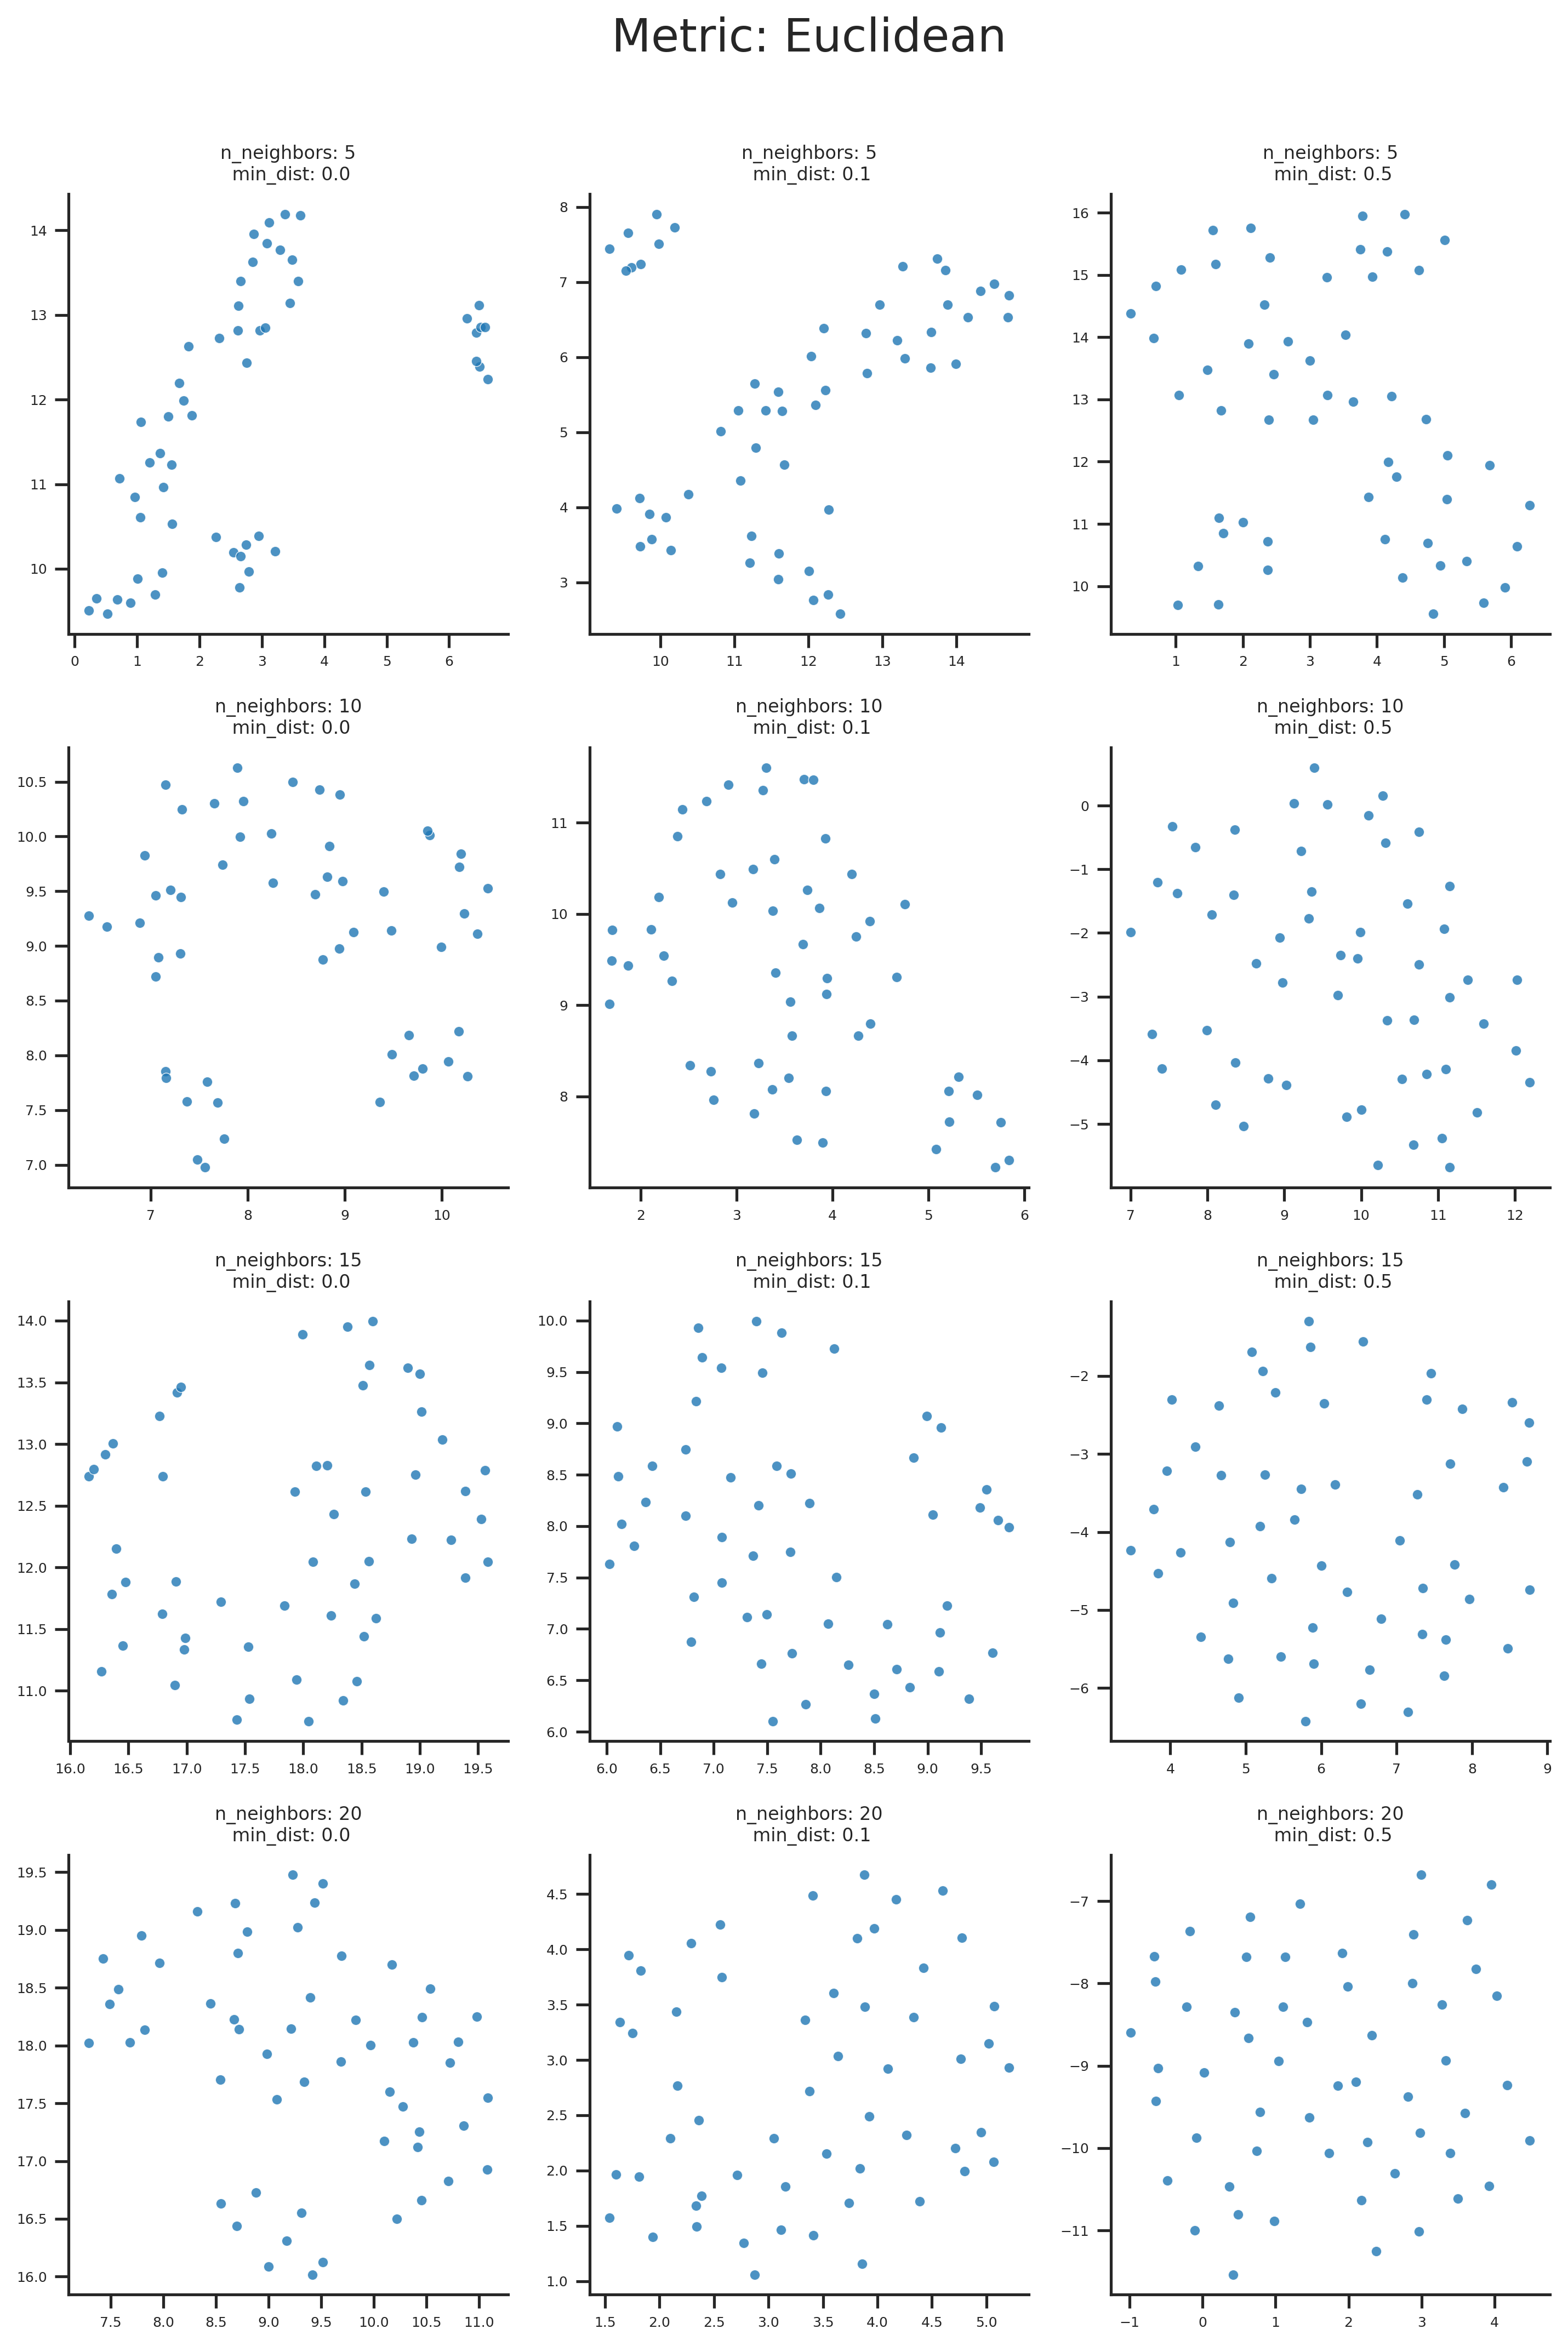

In [206]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,15))
for i in range(4):
    for j in range(3):
        n_neighbors = params["n_neighbors"][i]
        min_dist = params["min_dist"][j]
        metric = params["metric"][0]
            
        plot_umap(patients_std, metric, n_neighbors, min_dist, axs[i][j])

fig.suptitle(f"Metric: {metric.title()}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.savefig("../Figures/UMAP_multiples_euclidean")

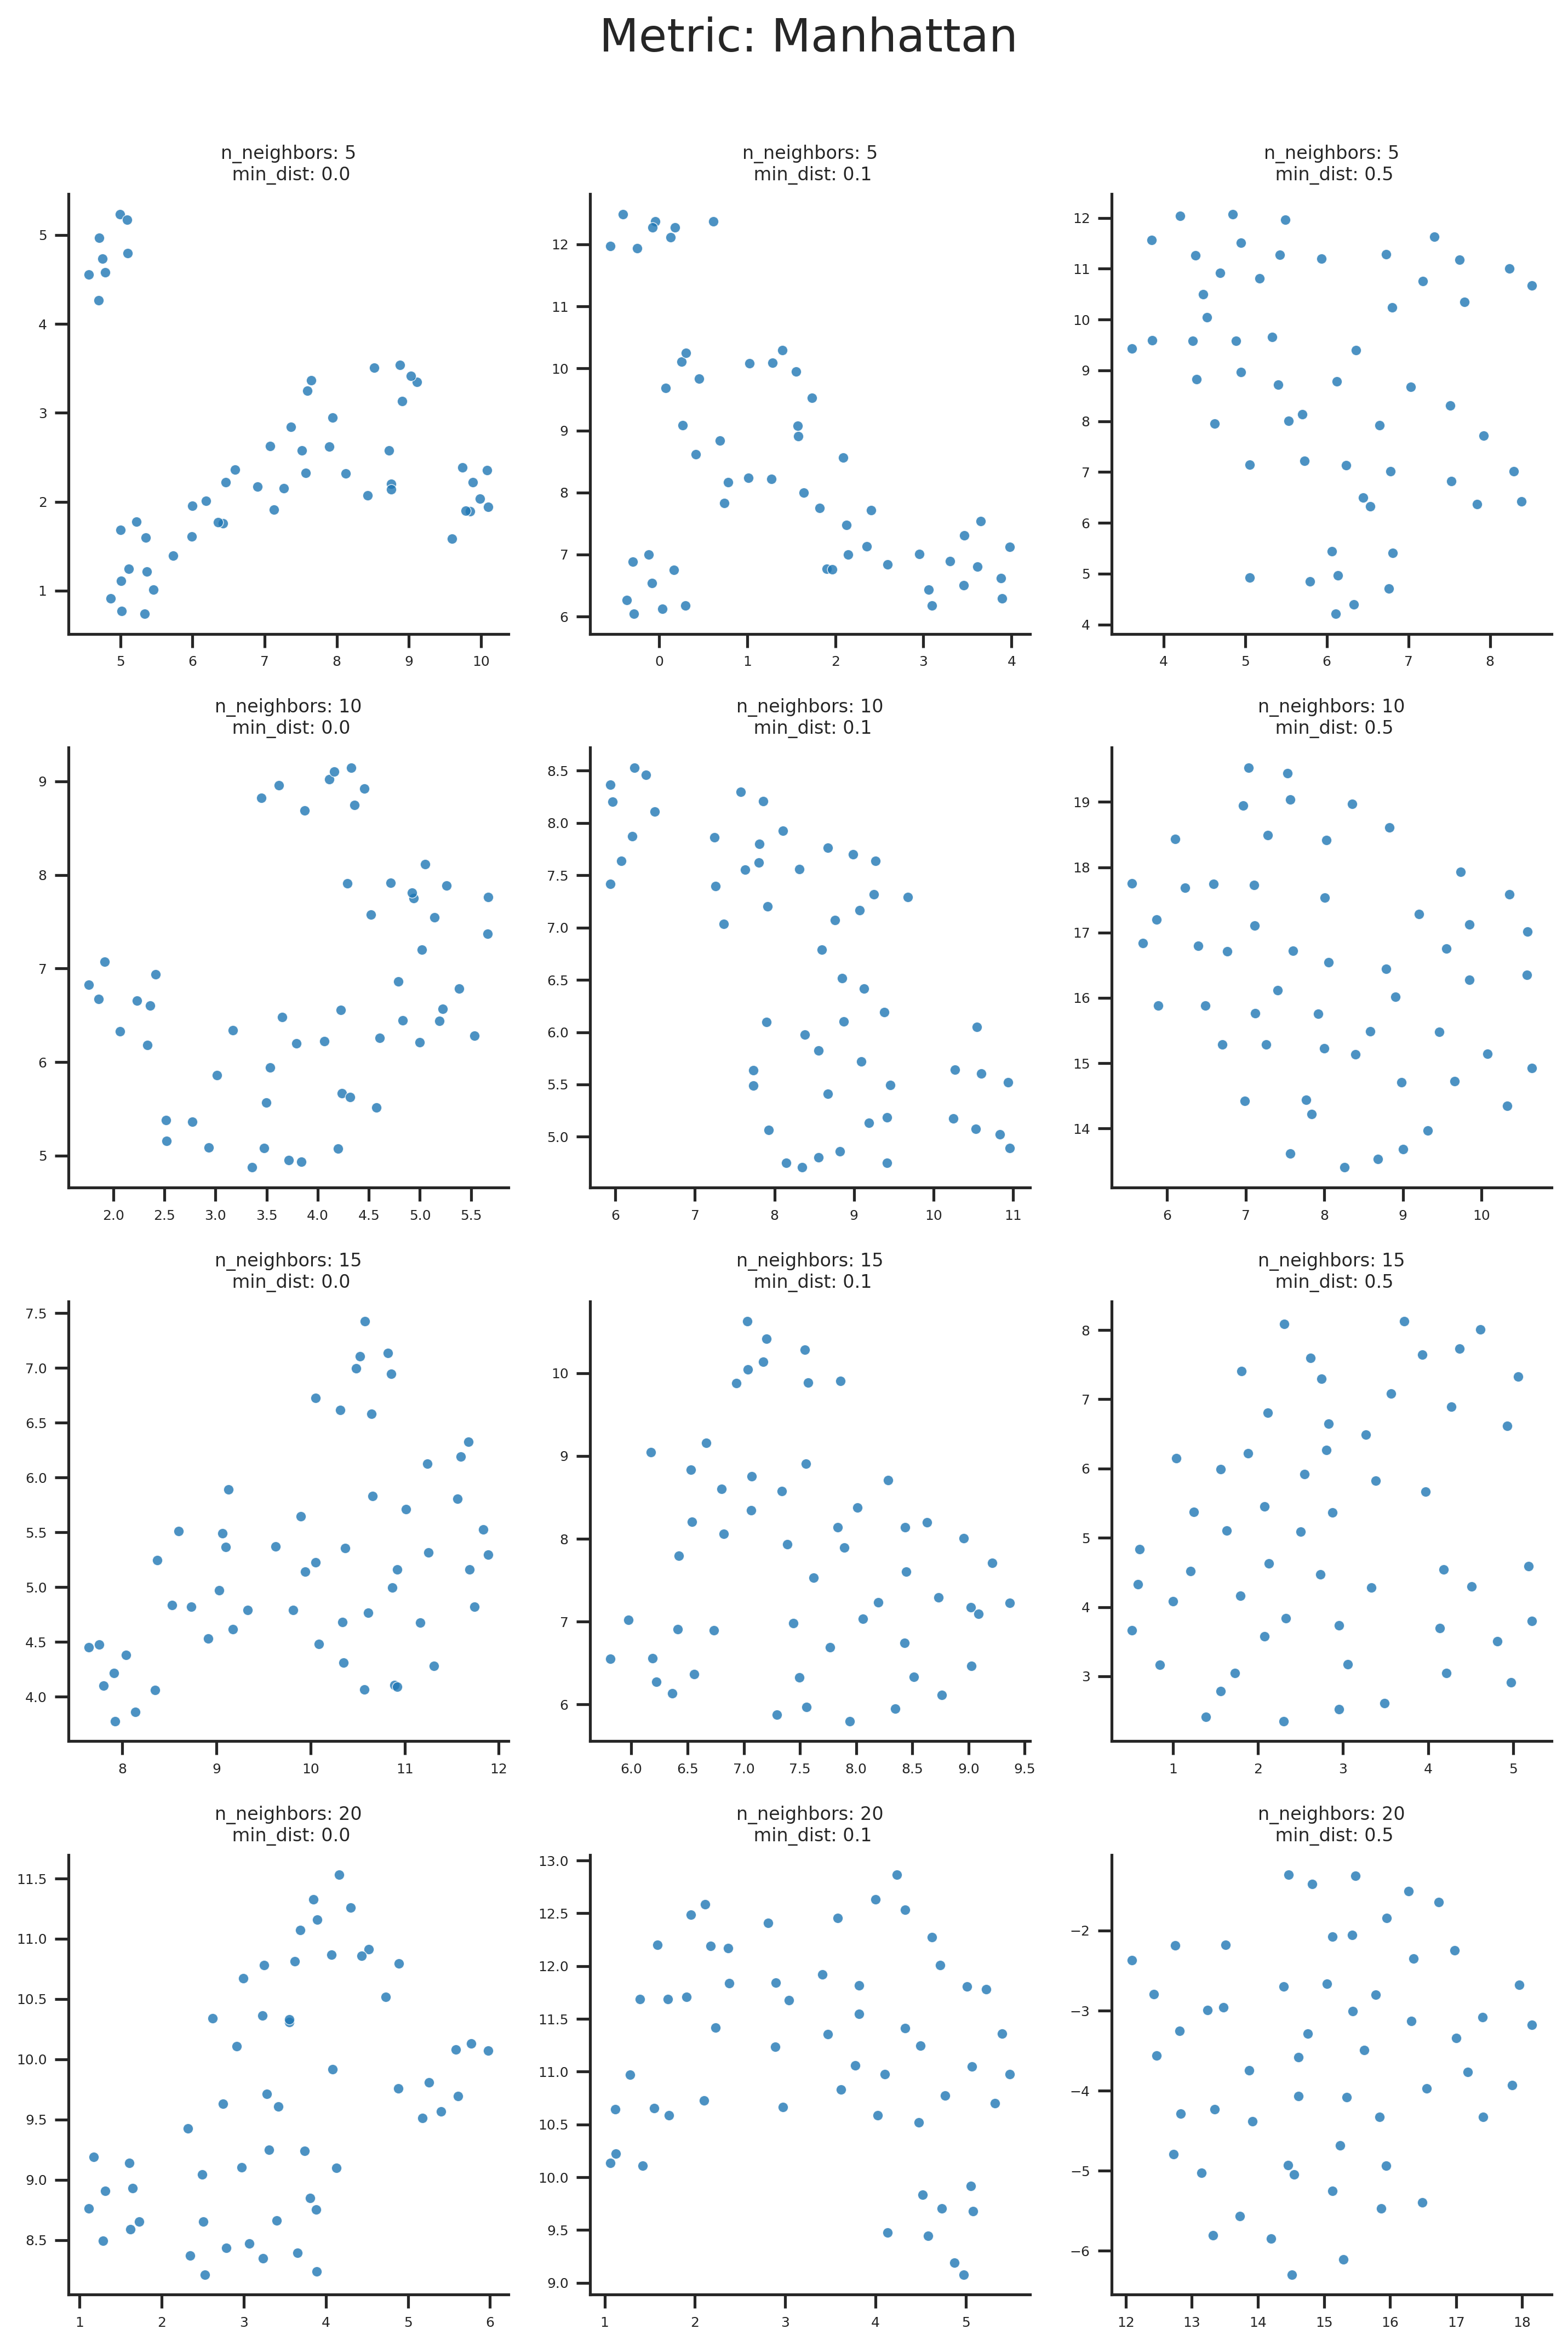

In [204]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,15))
for i in range(4):
    for j in range(3):
        n_neighbors = params["n_neighbors"][i]
        min_dist = params["min_dist"][j]
        metric = params["metric"][1]
            
        plot_umap(patients_std, metric, n_neighbors, min_dist, axs[i][j])

fig.suptitle(f"Metric: {metric.title()}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.savefig("../Figures/UMAP_multiples_Manhattan")

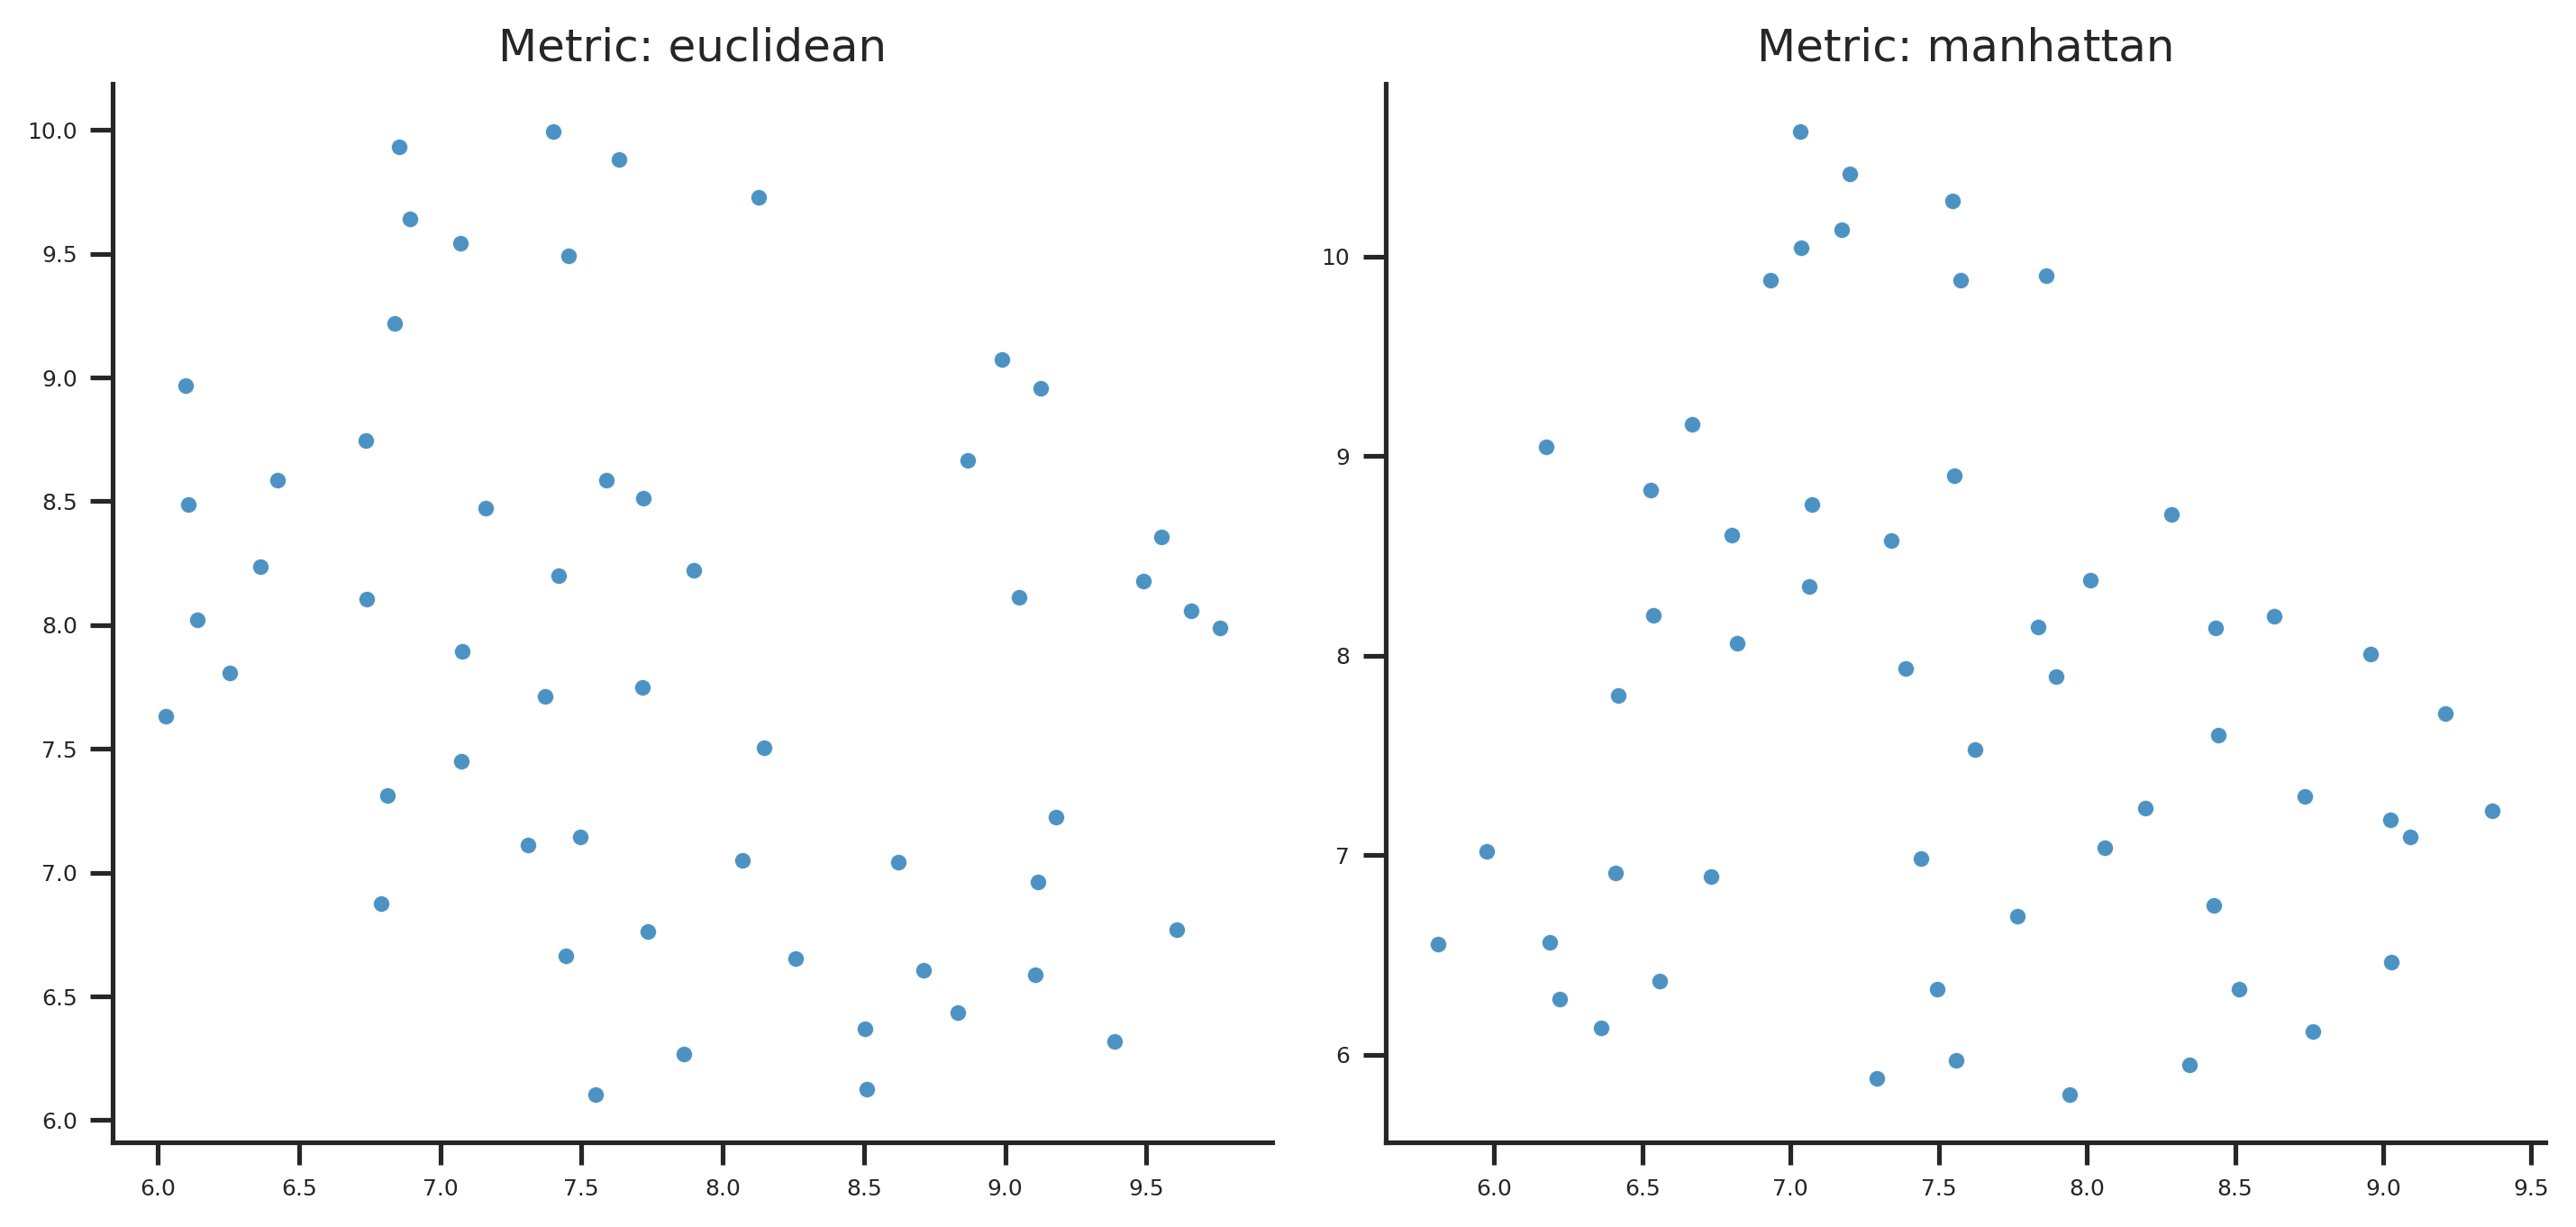

In [239]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i in range(2):
        n_neighbors = 15
        min_dist = 0.1
        metric = params["metric"][i]
            
        plot_umap(patients_std, metric, n_neighbors, min_dist, axs[i], set_title=False)

        axs[i].set_title(f"Metric: {metric}", fontsize=12) # Set title

# fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.savefig("../Figures/UMAP")

## PCA

In [240]:
def plot_pca(X, n_components, ax, set_title=True):

    pca = PCA(n_components)
    
    X_transformed = pca.fit_transform(X)
    print(sum(pca.explained_variance_ratio_))

    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], palette="tab10", s=20, alpha=0.8, ax=ax, legend=False)
    
    # Layout
    if set_title == True:
        ax.set_title(f"n_components{n_components}", fontsize=8) # Set title
    ax.tick_params(axis='both', labelsize=6) # Reduce tick label font size

0.23423641694328096


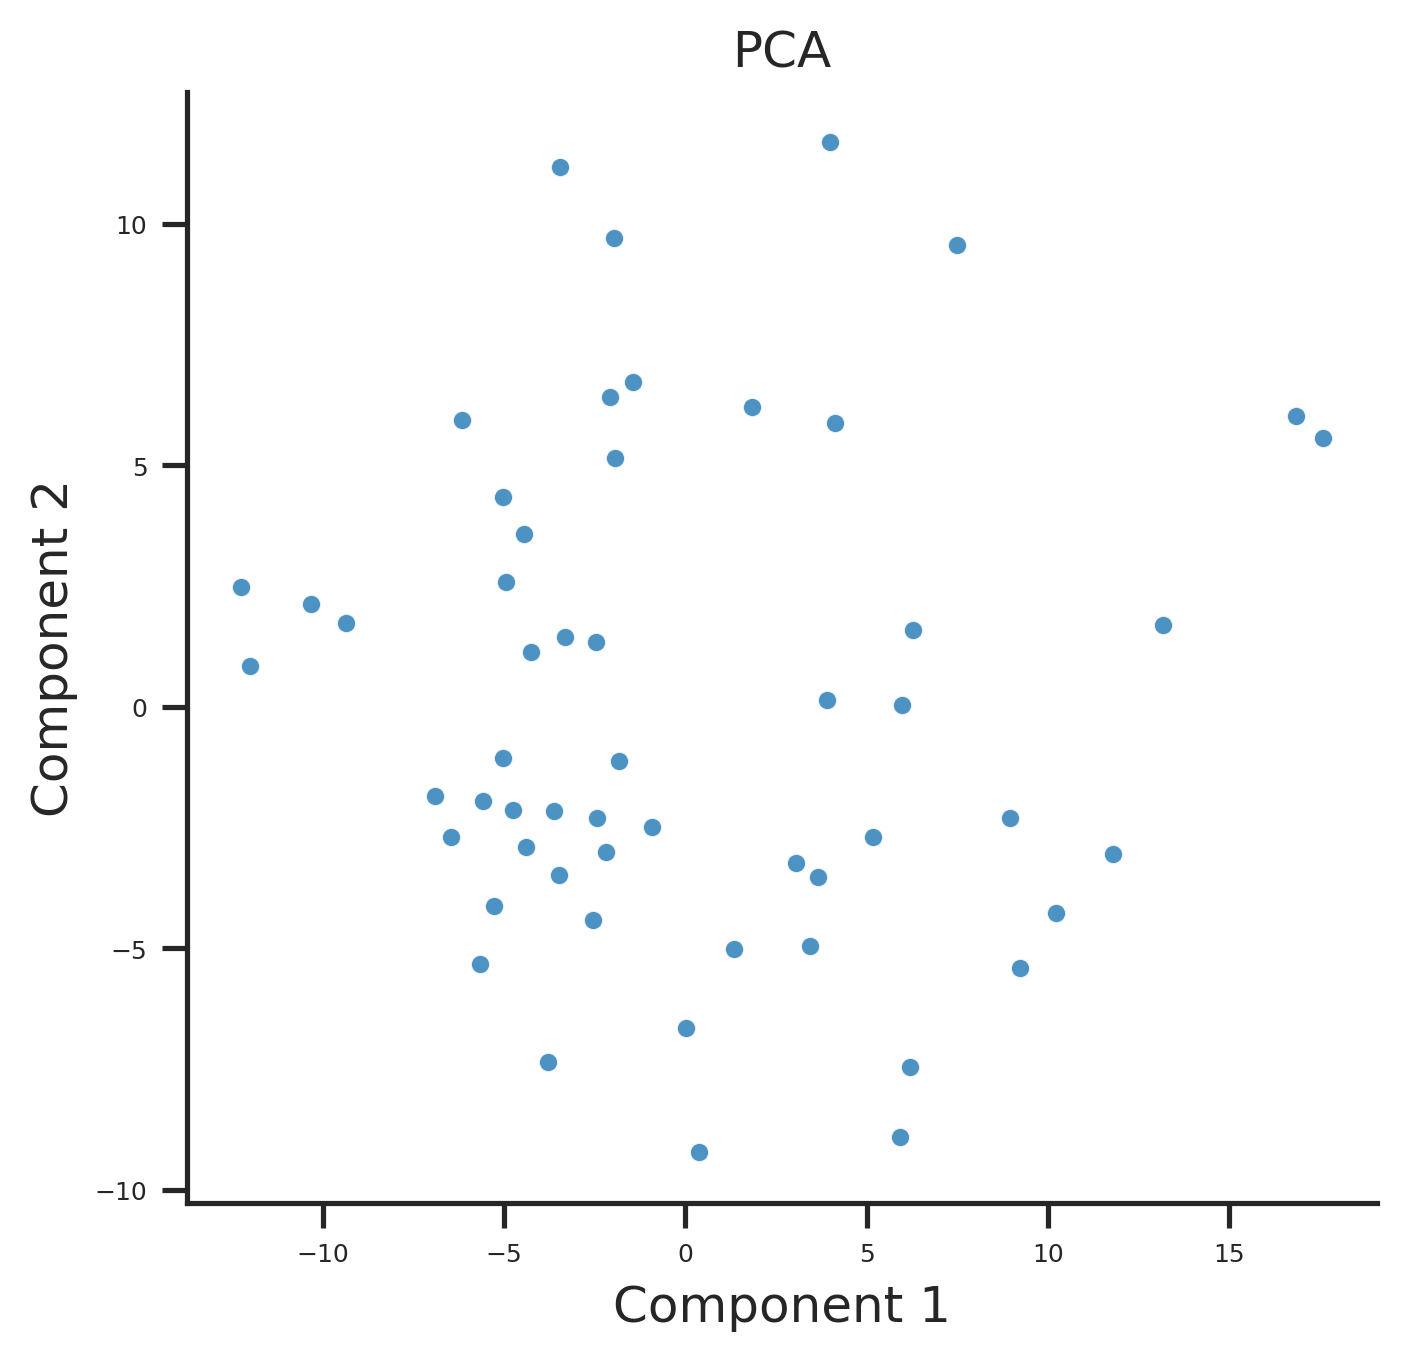

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
n_components = 2
    
plot_pca(patients_std, n_components, axs, set_title=False)
axs.set_title("PCA", fontsize=12) # Set title
axs.set_ylabel("Component 2")
axs.set_xlabel("Component 1")

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.savefig("../Figures/PCA")

## Reachability

In [247]:
def plot_reachability(X, metric, n_components, reducer, ax, n_neighbors=None, min_dist=None, min_samples=None, plot_type="lineplot", set_title=True):

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,         # smaller = more local focus, higher = more global
        min_dist=min_dist,           # smaller = tighter clusters, higher = more spread
        n_components=n_components,         
        metric=metric,     
        random_state=42
    )
    optics_model = OPTICS(
        min_samples=min_samples,
        xi=0.05,              # sensitivity for cluster detection (lower = more sensitive)
        metric=metric     # must match UMAP if used for clustering
    )
    
    if reducer == "PCA":
        pca = PCA(n_components)
        X_reduced = pca.fit_transform(X)
    elif reducer == "UMAP": 
        X_reduced = umap_model.fit_transform(X)
    else:
        X_reduced = X
    
    optics_model.fit(X_reduced)
    labels = optics_model.labels_
    
    # Generate a color palette that matches the UMAP scatter plot
    clusters = np.unique(labels[labels != -1])  # exclude noise for coloring
    palette = sns.color_palette("tab10", n_colors=len(clusters))
    label_color_map = {label: palette[i] for i, label in enumerate(clusters)}
    label_color_map[-1] = (0.85, 0.85, 0.85)
    
    # Sort labels and reachability distances by OPTICS ordering
    space = np.arange(len(optics_model.ordering_))
    reachability = optics_model.reachability_[optics_model.ordering_]
    labels = optics_model.labels_[optics_model.ordering_]

    if plot_type == "lineplot":
        sns.lineplot(x=space, y=reachability, size=10, alpha=0.8, ax=ax, legend=False, label=min_samples)
    else: 
        sns.scatterplot(x=space, y=reachability, hue=labels, palette=label_color_map, size=10, alpha=0.8, ax=ax, legend=False)
    
    # Layout
    if set_title:
        if reducer == "UMAP":
            ax.set_title(f"metric: {metric}\nn_neighbors: {n_neighbors}\n min_dist: {min_dist}\nmin_samples: {min_samples}", fontsize=8) # Fontsize
        elif reducer == "PCA":
            ax.set_title(f"n_components: {pca.n_components_}\nExplained variance: {sum(pca.explained_variance_ratio_):.2f}", fontsize=8) # Fontsize
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # Limit decimal precision on ticks
    ax.tick_params(axis='both', labelsize=6) # Reduce tick label font size

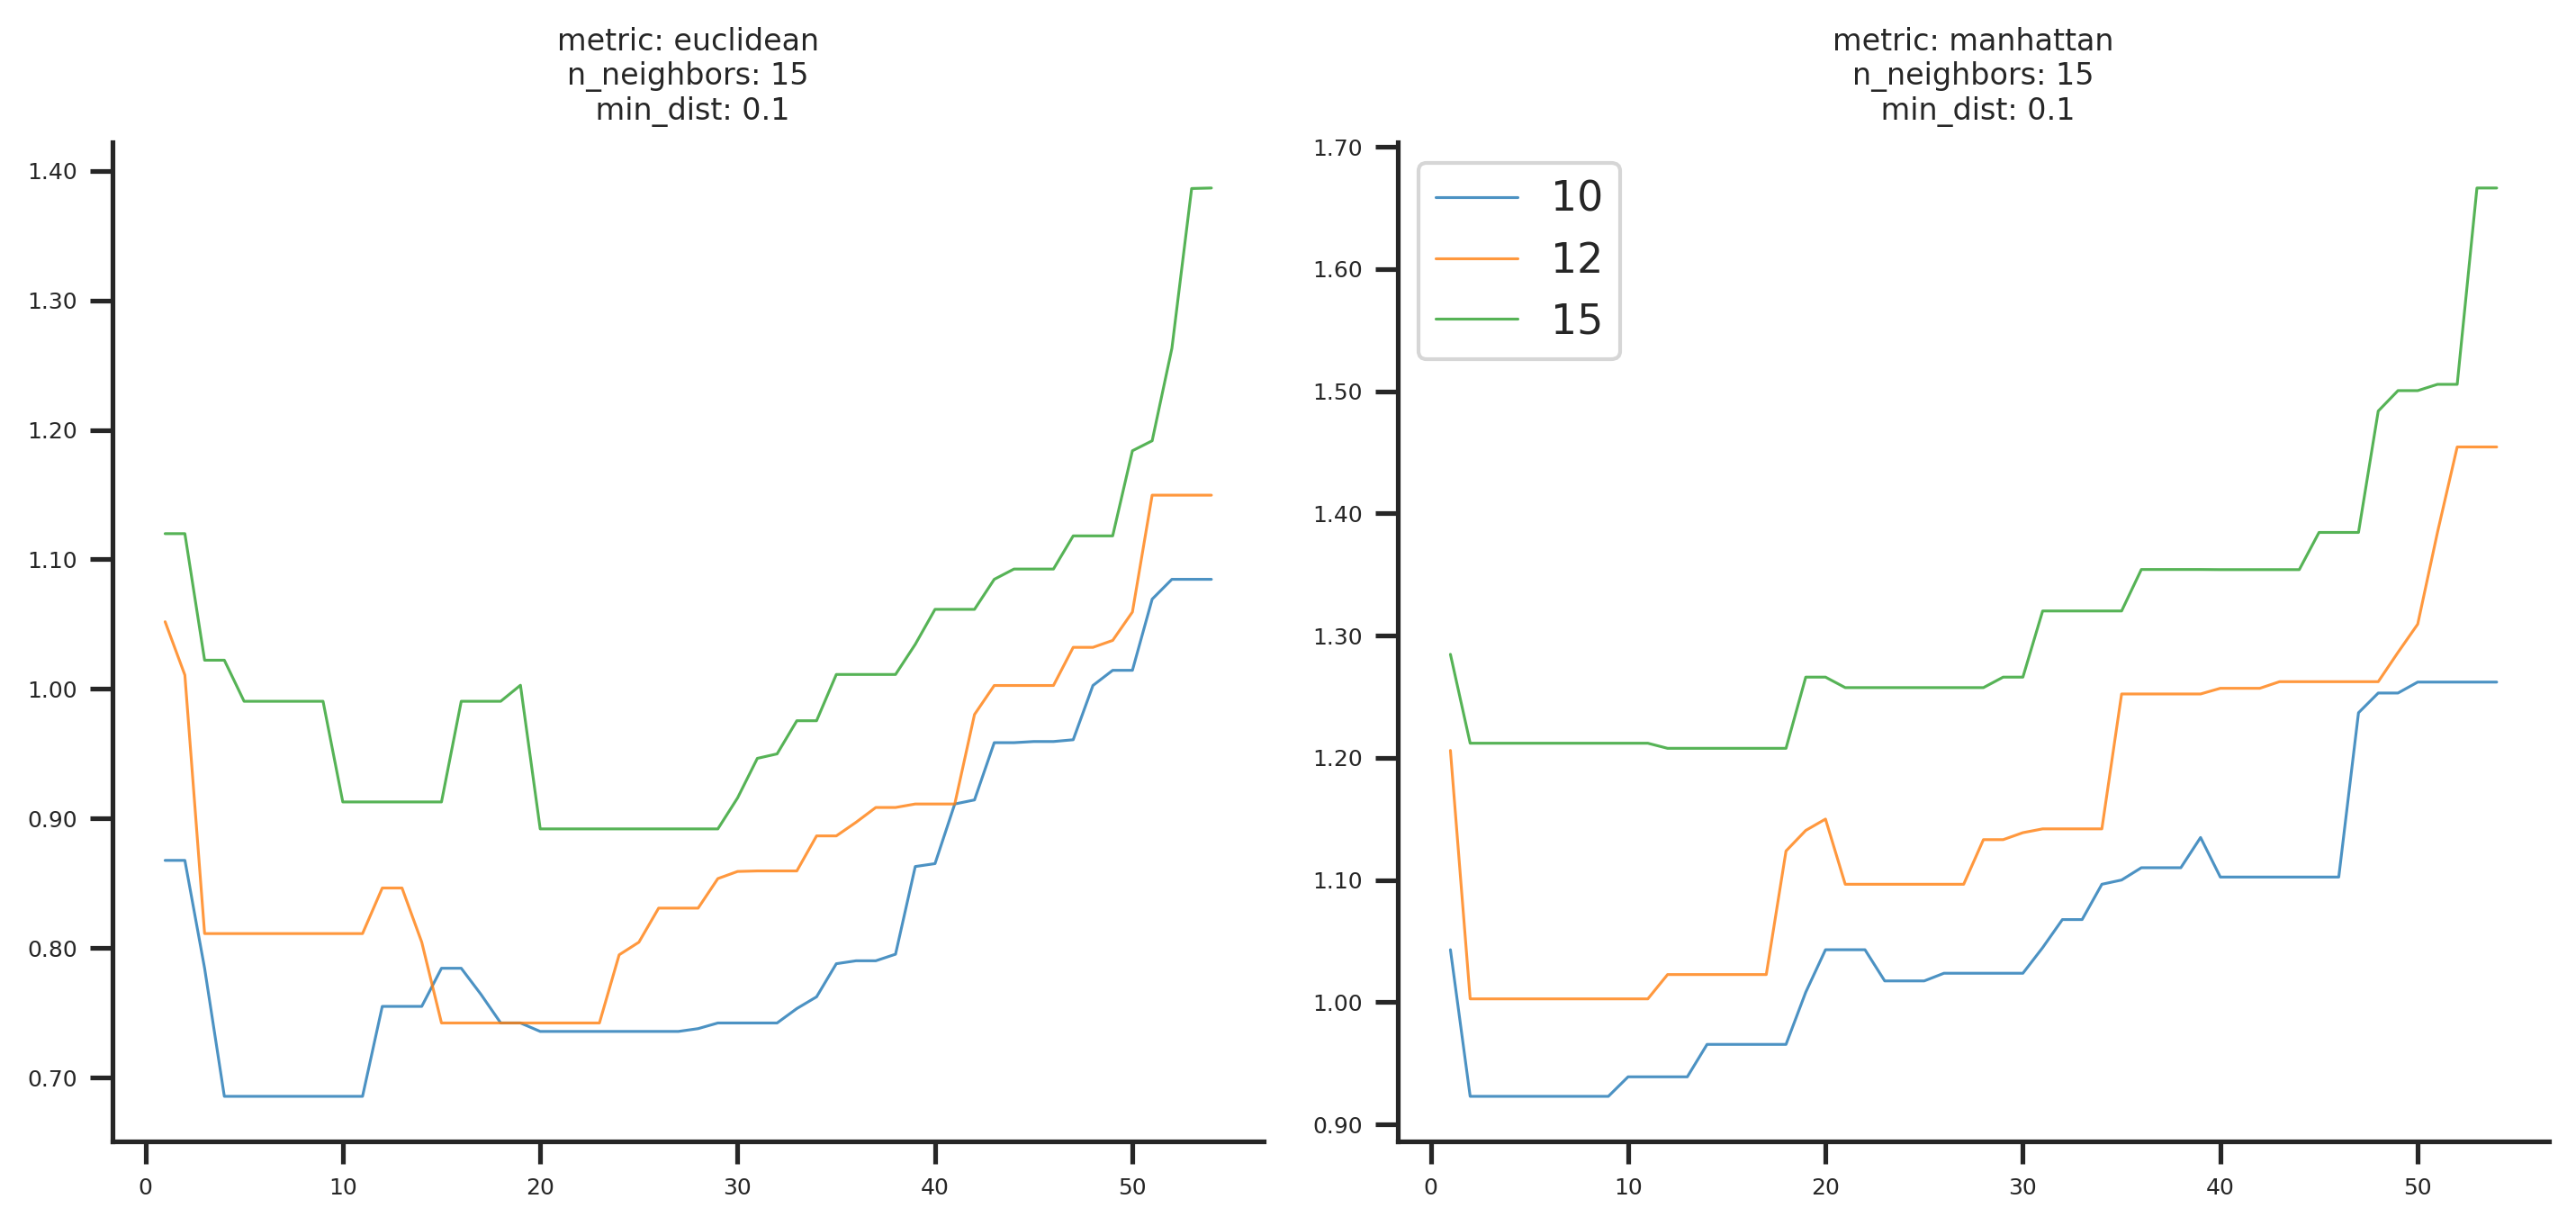

In [224]:
umap_params = {
    "n_neighbors" : 15,
    "min_dist" : 0.1,
    "metric" : ["euclidean", "manhattan"]
}
optic_params = {
    "min_samples" : [10, 12, 15]
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i in range(3):
    for j in range(2):
        min_samples = optic_params["min_samples"][i]
        
        min_dist = umap_params["min_dist"]
        n_neighbors = umap_params["n_neighbors"]
        metric = umap_params["metric"][j]
            
        plot_reachability(patients_std, metric, 2, "UMAP", axs[j], n_neighbors, min_dist, min_samples, "lineplot", set_title=False)
        axs[j].set_title(f"metric: {metric}\nn_neighbors: {n_neighbors}\n min_dist: {min_dist}", fontsize=8)
    
# fig.legend(optic_params["min_samples"])
plt.legend()

# fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.savefig("../Figures/reachability_plot_UMAP")

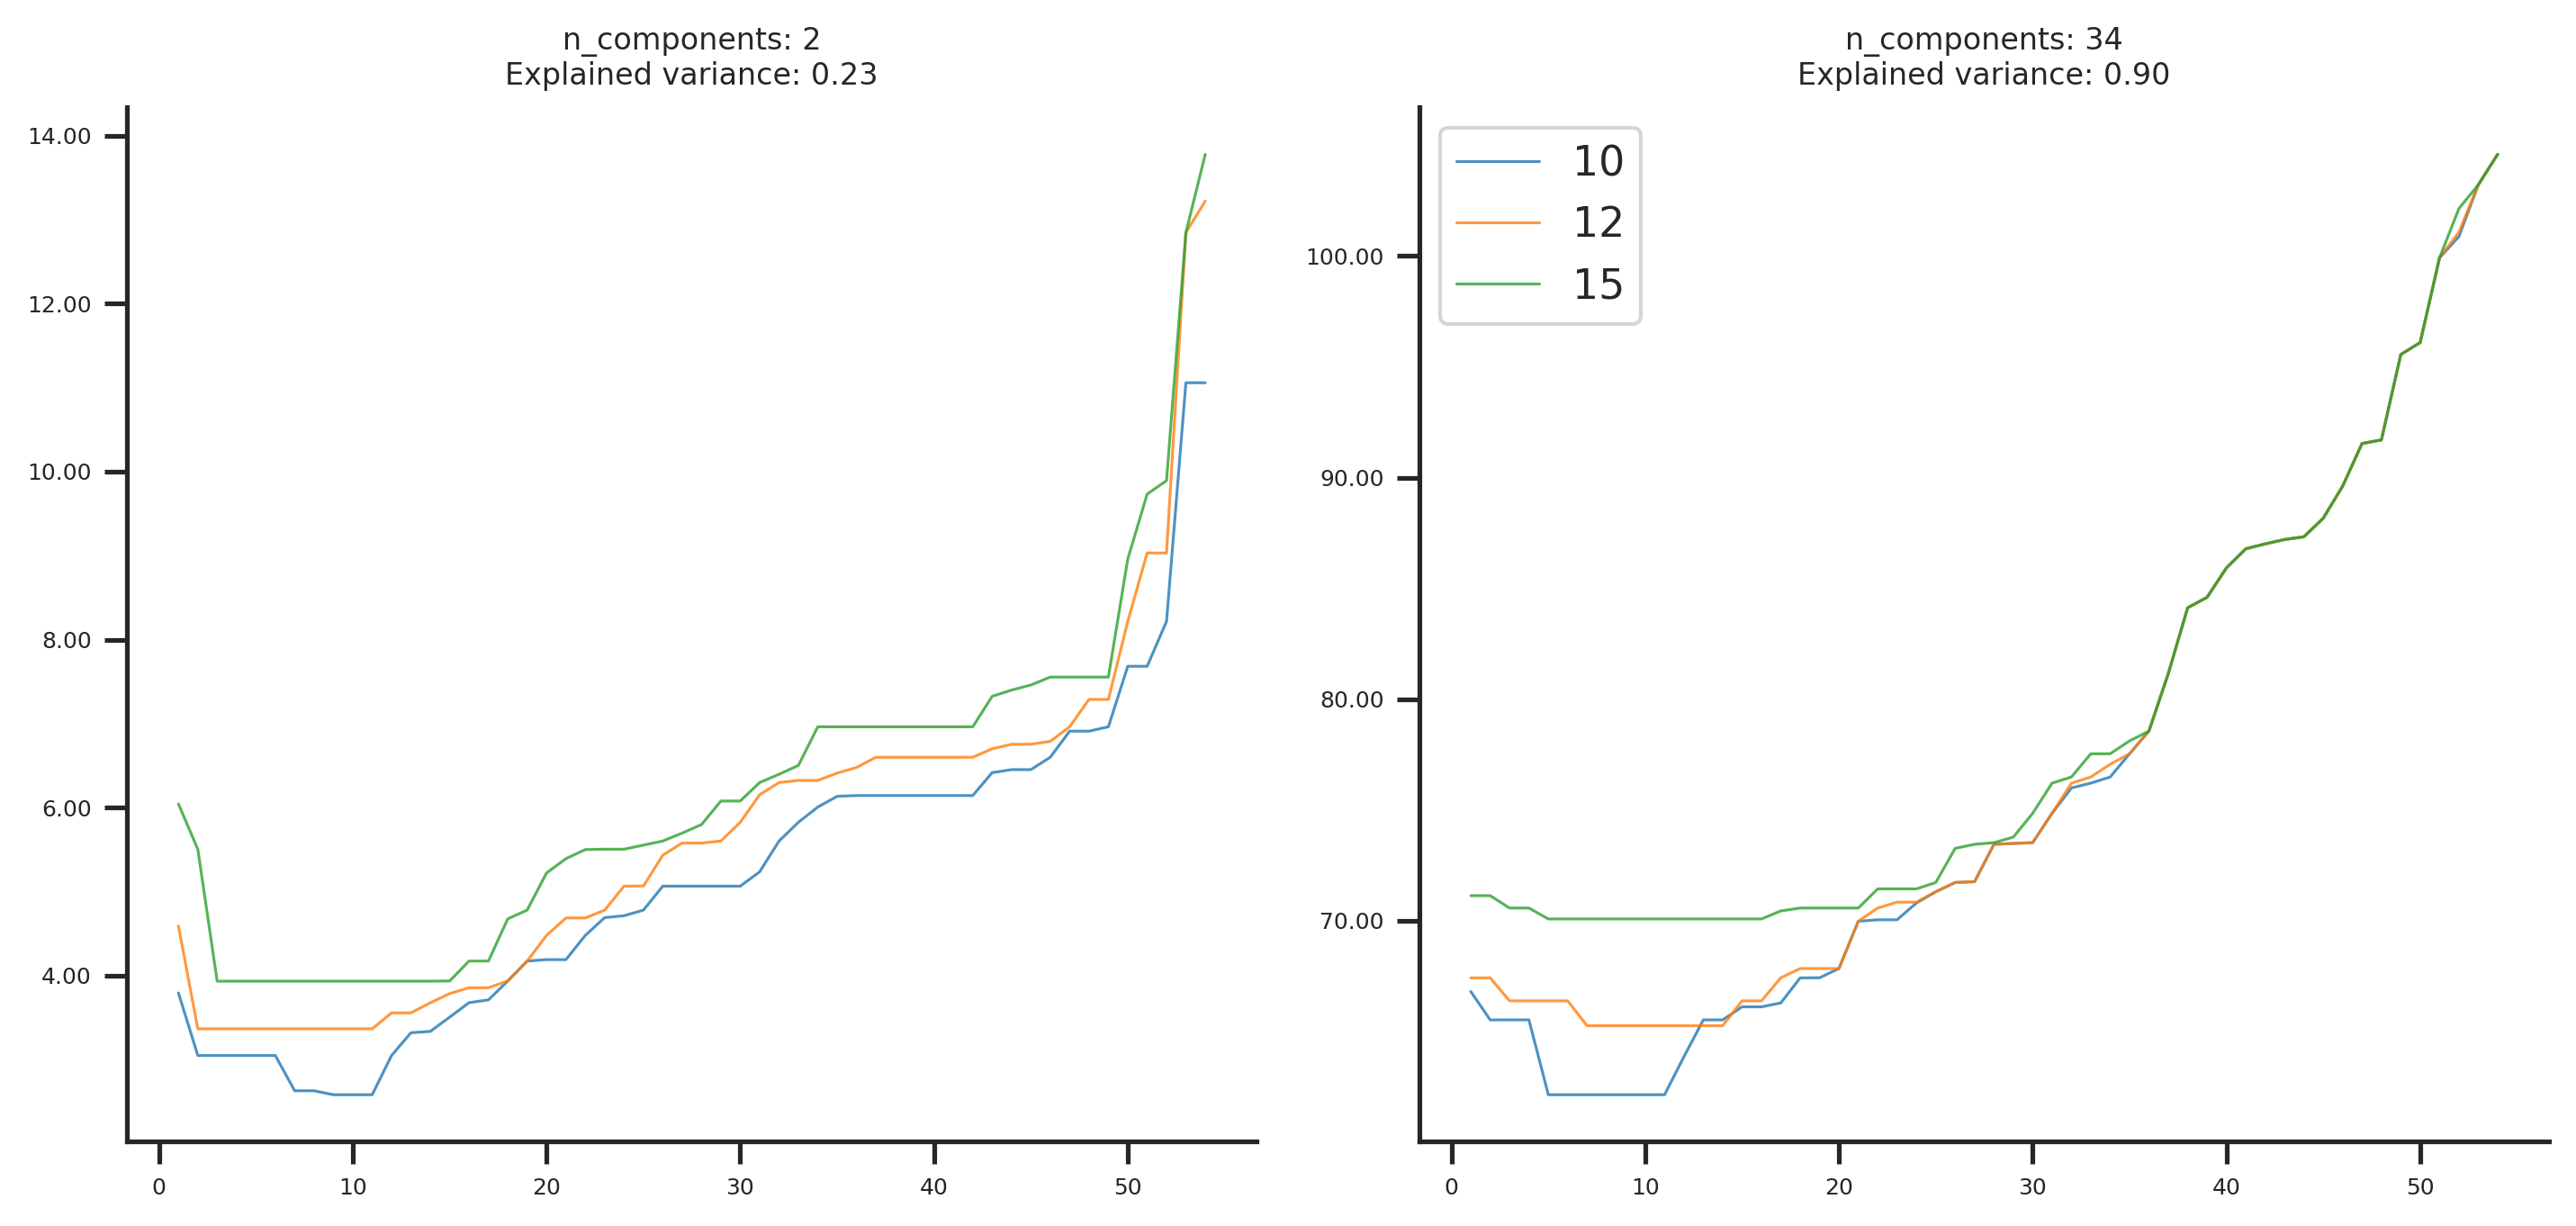

In [248]:
pca_params = {
    "n_components" : [0.20, 0.90]
}
optic_params = {
    "min_samples" : [10, 12, 15]
}


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i in range(3):
    for j in range(2):
        min_samples = optic_params["min_samples"][i]
        n_components = pca_params["n_components"][j]
            
        plot_reachability(patients_std, metric, n_components, "PCA", axs[j], n_neighbors, min_dist, min_samples, "lineplot", set_title=True)
    
# fig.legend(optic_params["min_samples"])
plt.legend()

# fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.savefig("../Figures/reachability_plot_PCA")

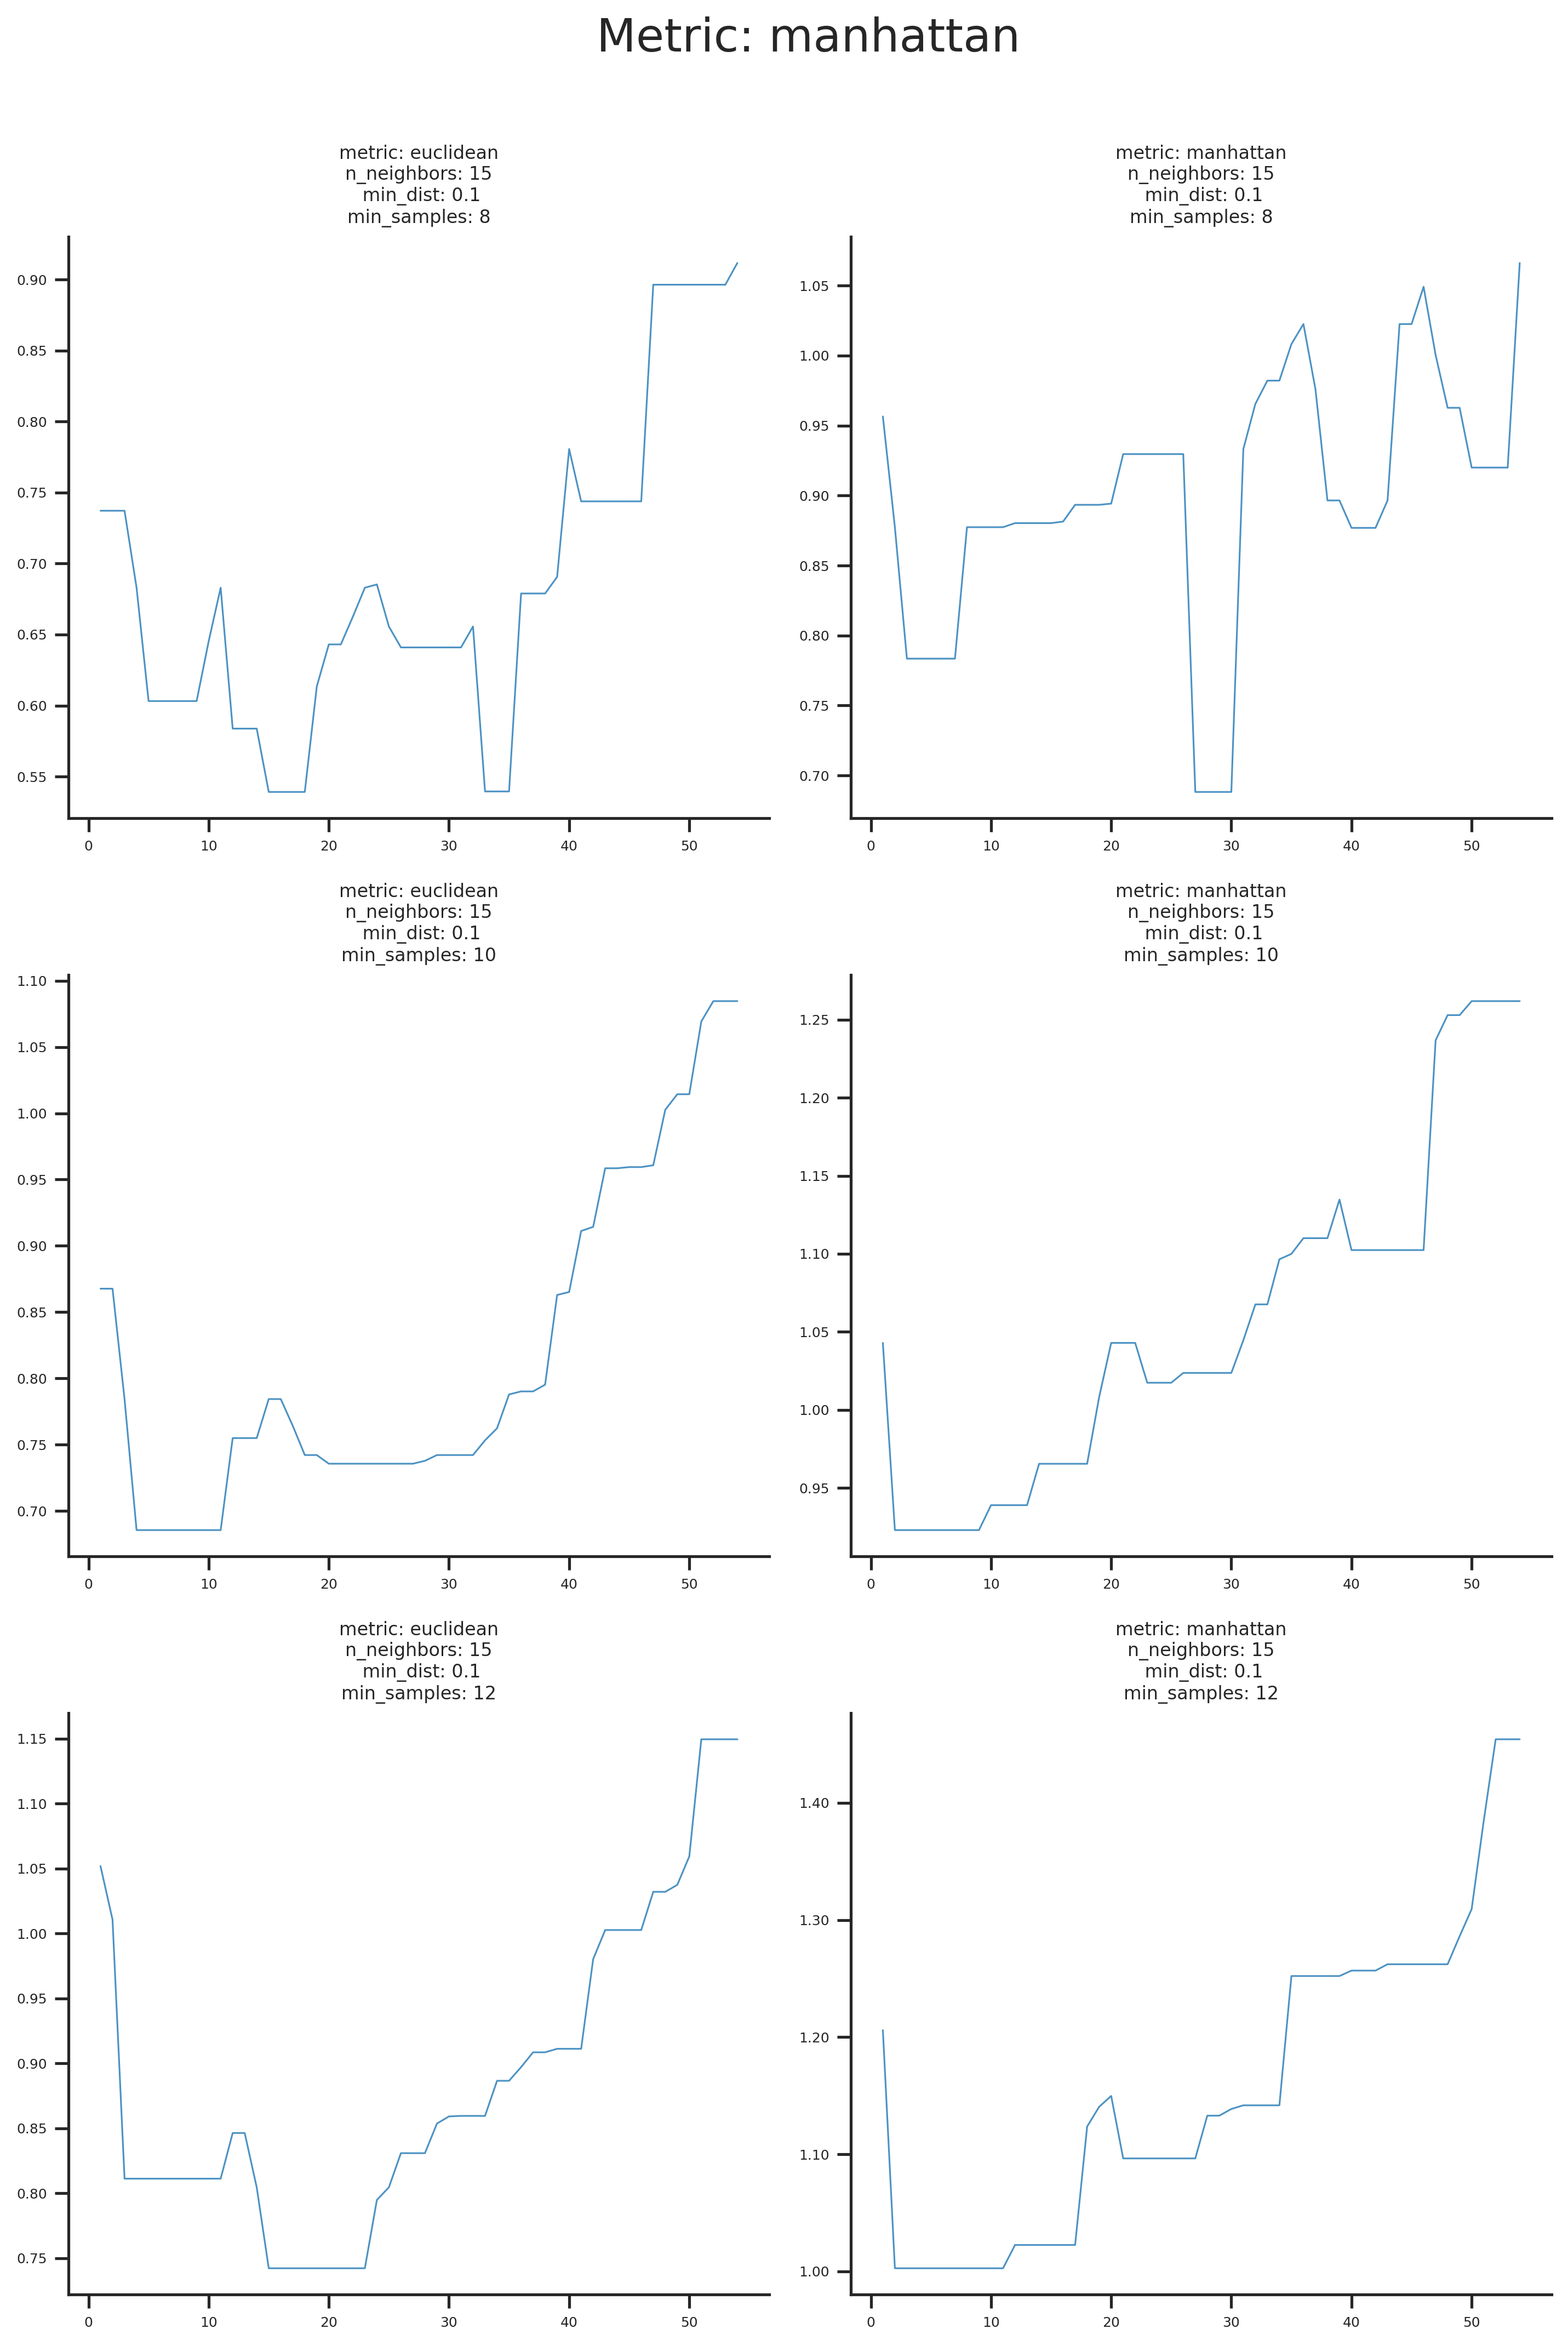

In [192]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
for i in range(3):
    for j in range(2):
        min_samples = optic_params["min_samples"][i]
        
        min_dist = umap_params["min_dist"]
        n_neighbors = umap_params["n_neighbors"]
        metric = umap_params["metric"][j]
            
        plot_reachability(patients_std, metric, n_neighbors, min_dist, min_samples, "UMAP", axs[i][j], "lineplot")

fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.show()

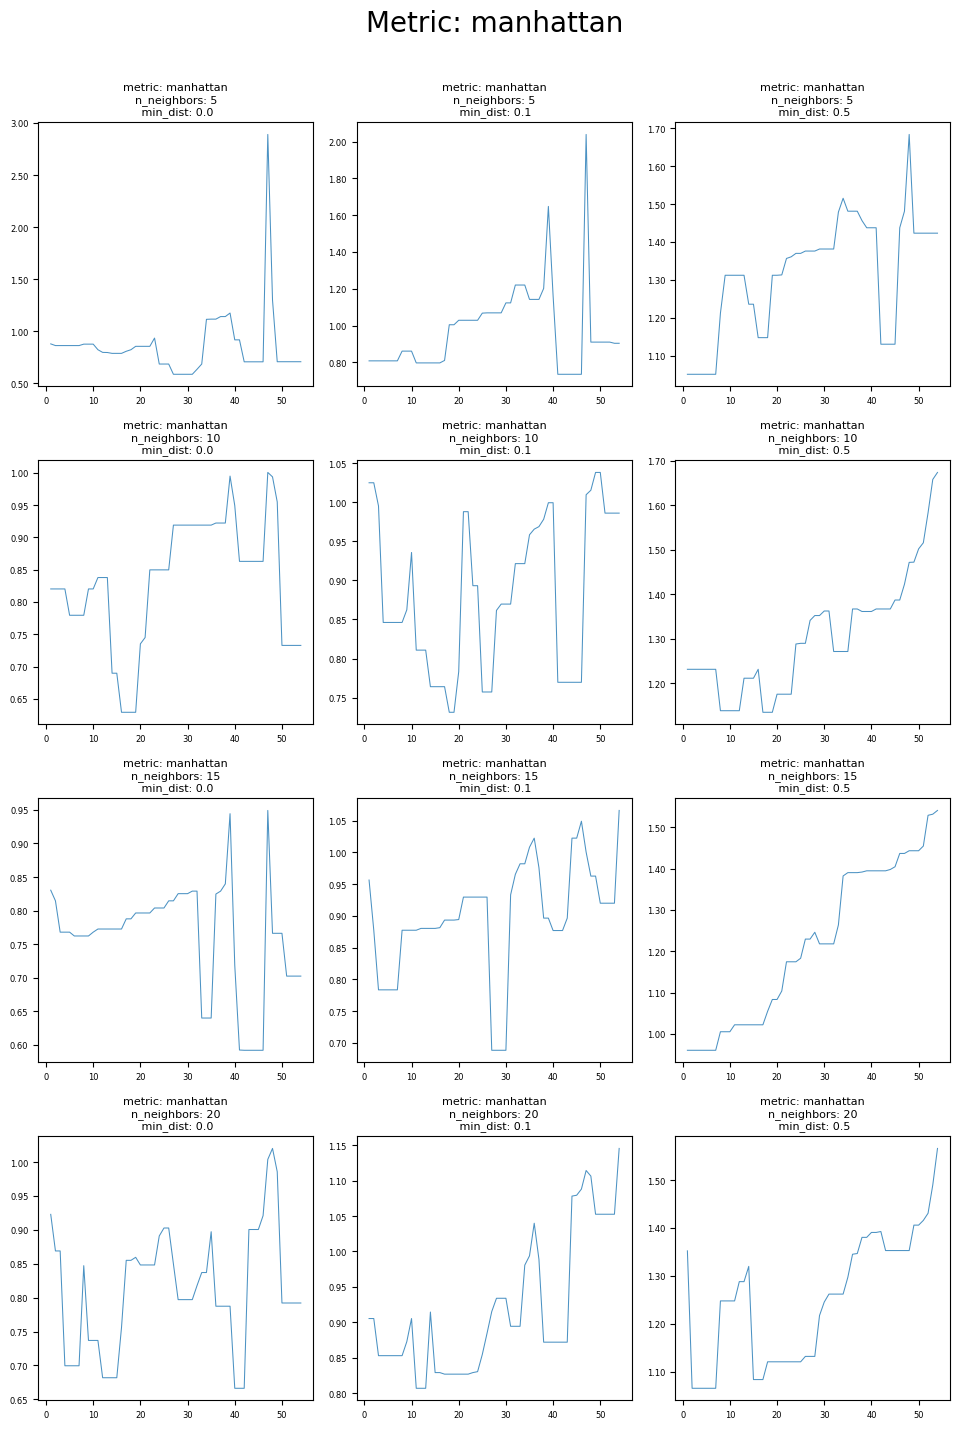

In [37]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,15))
for i in range(4):
    for j in range(3):
        n_neighbors = params["n_neighbors"][i]
        min_dist = params["min_dist"][j]
        metric = params["metric"][1]
            
        plot_reachability(patients_std, metric, n_neighbors, min_dist, "UMAP", axs[i][j])

fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.show()

## UMAP with OPTICS

In [ ]:
def plot_umap(X, metric, n_neighbors, min_dist, ax):

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,         # smaller = more local focus, higher = more global
        min_dist=min_dist,           # smaller = tighter clusters, higher = more spread
        n_components=2,         
        metric=metric,     
        random_state=42
    )
    optics_model = OPTICS(
        min_samples=5,
        xi=0.05,              # sensitivity for cluster detection (lower = more sensitive)
        min_cluster_size=0.05, # fraction or count of minimum cluster size
        metric=metric     # must match UMAP if used for clustering
    )
    
    X_transformed = umap_model.fit_transform(X)
    
    optics_model.fit(X_transformed)
    labels = optics_model.labels_
    
    # Generate a color palette that matches the UMAP scatter plot
    clusters = np.unique(labels[labels != -1])  # exclude noise for coloring
    palette = sns.color_palette("tab10", n_colors=len(clusters))
    label_color_map = {label: palette[i] for i, label in enumerate(clusters)}
    label_color_map[-1] = (0.85, 0.85, 0.85)

    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette=label_color_map, s=20, alpha=0.8, ax=ax, legend=False)
    
    # Layout
    ax.set_title(f"n_neighbors: {n_neighbors}\n min_dist: {min_dist}", fontsize=8) # Set title
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # Limit decimal precision on ticks
    ax.tick_params(axis='both', labelsize=6) # Reduce tick label font size

In [ ]:
umap_params = {
    "n_neighbors" : 15,
    "min_dist" : 0.1,
    "metric" : ["euclidean", "manhattan"]
}

optic_params = {
    "min_samples" : [10, 12, 15]
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_umap(patients_std, "euclidean", 15, 0.1, ax)